In [62]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#Load the dataset and extract target values
mdf= pd.read_csv('datasets/dd_train.csv')
target = mdf['Binding Affinity']
mdf.drop(columns='Binding Affinity',inplace=True)


In [63]:
#Importing Chem module
import rdkit
#from rdkit import Chem
#Transforming SMILES to MOL
mdf['mol'] = mdf['SMILES sequence'].apply(lambda x: rdkit.Chem.MolFromSmiles(x))


In [64]:
from rdkit import Chem

df = pd.DataFrame.copy(mdf)
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

print(df.shape, df.columns)

(9000, 8) Index(['SMILES sequence', 'mol', 'num_of_atoms', 'num_of_heavy_atoms',
       'num_of_C_atoms', 'num_of_O_atoms', 'num_of_N_atoms',
       'num_of_Cl_atoms'],
      dtype='object')


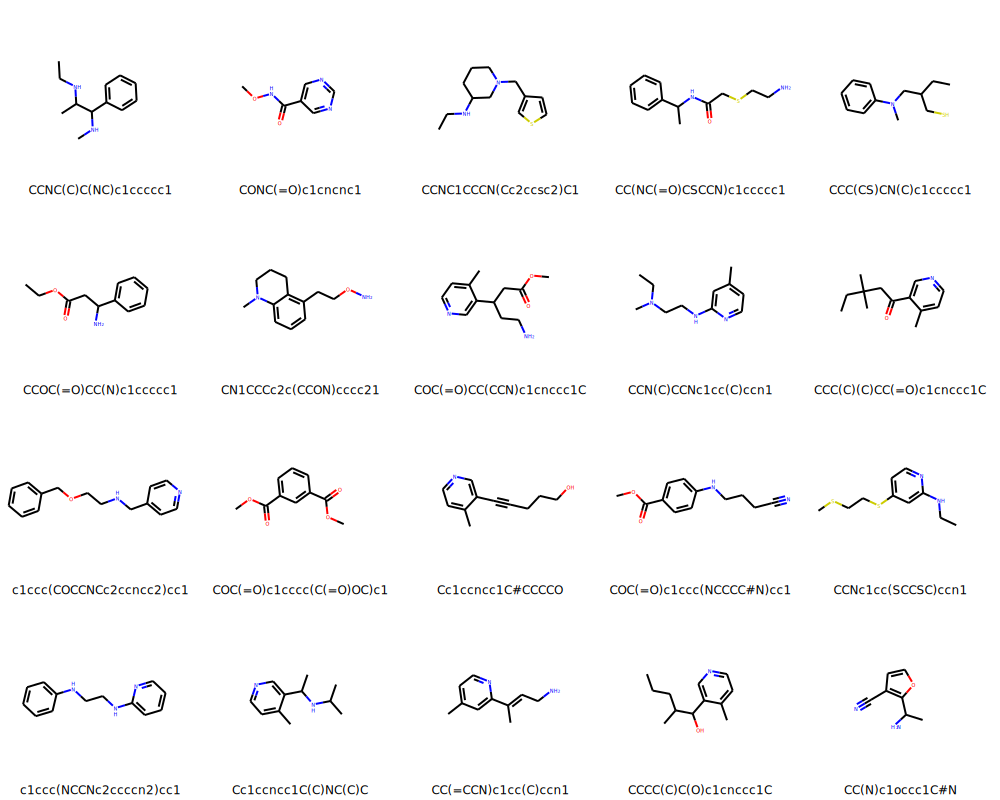

In [65]:
from rdkit.Chem import Draw
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

mols = mdf['mol'][:20]

nms=[x[0] for x in Descriptors._descList]

#MolsToGridImage allows to paint a number of molecules at a time
Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(mdf['SMILES sequence'][:20].values))




In [66]:
#Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('model_300dim.pkl')


In [67]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
#Constructing sentences
mdf['sentence'] = mdf.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
mdf['mol2vec'] = [DfVec(x) for x in sentences2vec(mdf['sentence'], model, unseen='UNK')]


In [68]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

X = np.array([x.vec for x in mdf['mol2vec']])
y = target.values
X.shape

(9000, 300)

In [72]:
#train_df = df.drop(columns = ['SMILES sequence', 'mol', 'sentence', 'mol2vec'])
#print(train_df.columns)





In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.metrics import mean_absolute_error, mean_squared_error
def evaluation(model, X_test, y_test, draw = False):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    if (draw == True):
        plt.figure(figsize=(15, 10))
        plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
        plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
        plt.legend()
        plt.ylabel('logP')
        plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
        plt.show()
    
        print('MAE score:', round(mae, 4))
        print('MSE score:', round(mse,4))
        
    return round(mae, 4), round(mse, 4)


def evaluate_regressor(X, y, reg, train_df):
    if (train_df is not None):
        mdf = pd.DataFrame(X)
        df = pd.concat((mdf, train_df), axis=1)
    else:
        df = X
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=.1, random_state=1)
    reg.fit(X_train, y_train)
    return evaluation(reg, X_test, y_test)


def all_regressors(X, y, train_df):
    reglist = [
                ('randomforest', RandomForestRegressor(max_depth=2, random_state=0)),
                ('adaboost', AdaBoostRegressor(n_estimators=100, learning_rate = 0.5, random_state=0)),
                ('ridge', RidgeCV(cv=5)),
                ('linearregression', LinearRegression())
                ]
    for (name, reg) in reglist:
        mae1, mse1 = evaluate_regressor(X, y, reg, None)
        mae2, mse2 = evaluate_regressor(X, y, reg, train_df)
        print(name)
        print("--- (Without additional data)", " MSE = ", mse1, " MAE = ", mae1)
        print("--- (With    additional data)", " MSE = ", mse2, " MAE = ", mae2)
        
                

In [75]:
'''
reg = RidgeCV(cv=5)
evaluate_regressor (X,
                    y,
                    AdaBoostRegressor(reg, n_estimators=100, learning_rate = 1, random_state=0),
                    None
                    )
'''

'\nreg = RidgeCV(cv=5)\nevaluate_regressor (X,\n                    y,\n                    AdaBoostRegressor(reg, n_estimators=100, learning_rate = 1, random_state=0),\n                    None\n                    )\n'

In [76]:
#X_train, X_test, y_train, y_test
reg = RidgeCV(cv=5)
(mae, mse) = evaluate_regressor(X, y, reg, None)
print("MSE = ", mse, " MAE = ", mae)
        

MSE =  5.6484  MAE =  1.7649


In [48]:
all_regressors(X, y, train_df)

randomforest
--- (Without additional data)  MSE =  11.7551  MAE =  2.5683
--- (With    additional data)  MSE =  10.7616  MAE =  2.4388
adaboost
--- (Without additional data)  MSE =  9.7564  MAE =  2.4603
--- (With    additional data)  MSE =  9.7763  MAE =  2.4438
ridge
--- (Without additional data)  MSE =  5.6484  MAE =  1.7649
--- (With    additional data)  MSE =  5.6566  MAE =  1.7652
linearregression
--- (Without additional data)  MSE =  5.6584  MAE =  1.7672
--- (With    additional data)  MSE =  5.669  MAE =  1.7677


In [89]:
import rdkit
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec


def process_X (df):
    df['mol'] = mdf['SMILES sequence'].apply(lambda x: rdkit.Chem.MolFromSmiles(x))
    model = word2vec.Word2Vec.load('model_300dim.pkl')
    #Constructing sentences
    df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
    #Extracting embeddings to a numpy.array
    #Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
    df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], model, unseen='UNK')]
    
    X = np.array([x.vec for x in df['mol2vec']])
    return X
    



    

reg = RidgeCV(cv=5)
reg.fit(X, y)

#Load the dataset and extract target values
tdf= pd.read_csv('datasets/dd_test.csv')
tdf.drop(columns='Binding Affinity',inplace=True)
testX = process_X(tdf)

predicted_values = reg.predict(testX)
testy = pd.DataFrame((predicted_values), columns = ['Binding Affinity'])

tdf.drop(columns = ['mol', 'sentence', 'mol2vec'], inplace = True)
                               

Index(['SMILES sequence', 'mol', 'sentence', 'mol2vec'], dtype='object')
(2500, 300)
(2500, 1)


In [98]:
print(tdf.columns)

print(tdf.shape)
print(ytest.shape)
finaldf = pd.concat((tdf, ytest), axis = 1)
print(finaldf.shape)

#print(finaldf)
finaldf.columns
finaldf.to_csv('dd_submission.csv')

Index(['SMILES sequence'], dtype='object')
(2500, 1)
(2500, 1)
(2500, 2)
